In [164]:
import pandas as pd
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.simplefilter('ignore')

In [165]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
    
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [166]:
df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
df.shape

(278677, 9)

In [167]:
df.head()

reviewerID        asin                 reviewerName helpful  \
0  A1KLRMWW2FWPL4  0000031887  Amazon Customer "cameramom"  [0, 0]   
1  A2G5TCU2WDFZ65  0000031887              Amazon Customer  [0, 0]   
2  A1RLQXYNCMWRWN  0000031887                       Carola  [0, 0]   
3   A8U3FAMSJVHS5  0000031887                      Caromcg  [0, 0]   
4  A3GEOILWLK86XM  0000031887                           CJ  [0, 0]   

                                                                                                                                                                                                reviewText  \
0                             This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++   
1  I bought this for my 4 yr old daughter for dance class, she wore it today for the first time and the teacher thought it was adorable. I bought this to go with a light blue long sleeve leotard and ...   
2  What can I say... my daughters have it in orange, black, white and pink and I am thinking to buy for they the fuccia one. It is a very good way for exalt a dancer outfit: great colors, comfortable...   
3  We bought several tutus at once, and they are got high reviews. Sturdy and seemingly well-made. The girls have been wearing them regularly, including out to play, and the tutus have stood up well....   
4  Thank you Halo Heaven great product for Little Girls.  My Great Grand Daughters Love these Tutu's.  Will buy more from this seller.  Made well and cute on the girls.  Thanks for a great product.NE...   

   overall                        summary  unixReviewTime   reviewTime  
0      5.0  Great tutu-  not cheaply made      1297468800  02 12, 2011  
1      5.0                    Very Cute!!      1358553600  01 19, 2013  
2      5.0       I have buy more than one      1357257600   01 4, 2013  
3      5.0               Adorable, Sturdy      1398556800  04 27, 2014  
4      5.0        Grammy's Angels Love it      1394841600  03 15, 2014

In [171]:
df = df.sample(n=50000, random_state=1)

# Sentiment Analysis

In [172]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['reviewText'].apply(pol)
df['subjectivity'] = df['reviewText'].apply(sub)
df.head()

reviewerID        asin                         reviewerName  \
10773   A2AGUIRQZHZK7K  B0007LPM3W                       Jason Zurawski   
152404  A2FFWYG9YYZFA5  B005C2P31W                                  She   
105929  A2DMS2AADHQRTA  B003JZANUK                           H. Epstein   
33709   A24367KW657RM0  B000M49W1M                         Blackberrie6   
112712   AT3T99Y0CWNQ5  B003X4KKT6  victoria "We are all in Gods Hands"   

        helpful  \
10773    [0, 0]   
152404  [6, 10]   
105929   [0, 0]   
33709    [1, 1]   
112712   [0, 0]   

                                                                                                                                                                                                     reviewText  \
10773                                                                              These a super comfortable for walking, and work well on land and water.  Footbed is a little slick to start until broken in.   
152404  I bought the purple and grey, size 9.5 pair.  I have narrow, long feet and have a hard time finding shoes to wear, especially since I don't wear leather or suede.  Just about every shoe I try on i...   
105929                                                                                       I bought them for my husband for the winter months to keep feet worm.The slippers are light worm and true to size.   
33709   I have a nice pair of jeans that I thought these shoes would go well with, so I ordered them. They were very pretty, however they were snug across my toes. I ended up stretching the shoe out becau...   
112712  I can use these for walking, short hikes, camping, shower shoe - dries fast - ,  swimming, water sports, kayaking, small to carry along not buky, clean easily, But I would not suggest using these ...   

        overall                                        summary  \
10773       5.0                               Good wet and dry   
152404      5.0                            Great Walking Shoes   
105929      5.0                                 Light and worm   
33709       3.0                                         OUCH!!   
112712      5.0  these are great summer shoes for any activity   

        unixReviewTime   reviewTime  polarity  subjectivity  
10773       1403395200  06 22, 2014 -0.020833      0.548333  
152404      1328140800   02 2, 2012  0.119990      0.646924  
105929      1353974400  11 27, 2012  0.375000      0.675000  
33709       1327881600  01 30, 2012  0.231250      0.875000  
112712      1389052800   01 7, 2014  0.035714      0.619048

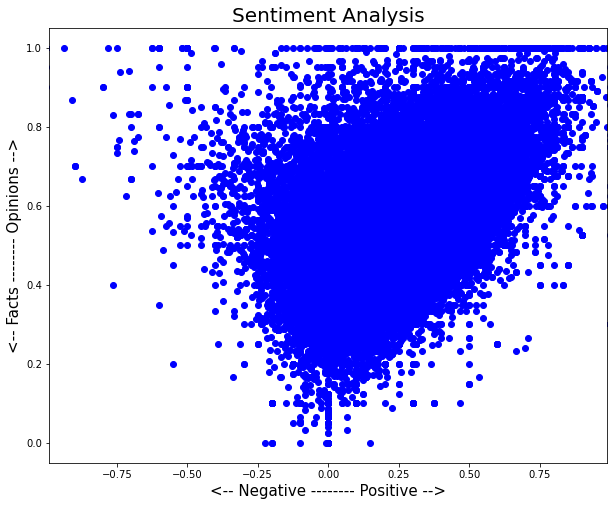

In [173]:
# Let's plot the results


plt.rcParams['figure.figsize'] = [10, 8]

for index, text in enumerate(df.index):
    x = df.polarity.loc[text]
    y = df.subjectivity.loc[text]
    plt.scatter(x, y, color='blue')
    plt.xlim(-.99, .99) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

# Text Clean
* Tokenizing, Stemming, remove stop words, remove punctuation and numbers

### (1) take a look at the original text (top 20 most frequent words)

In [174]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

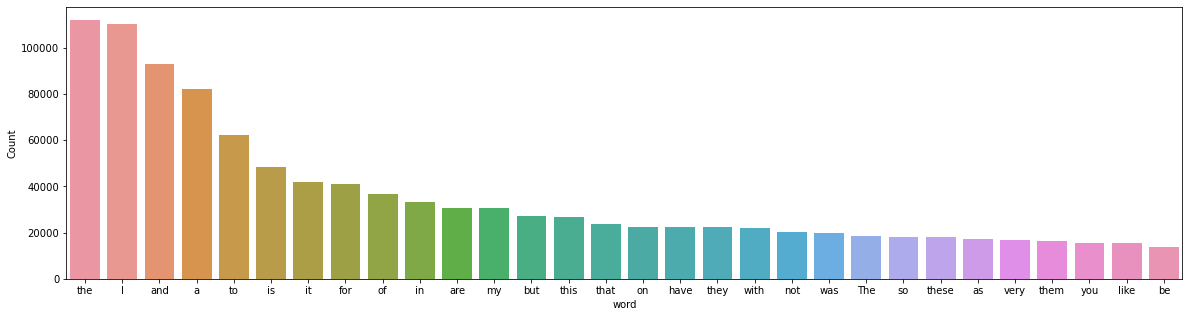

In [175]:
freq_words(df['reviewText'])

### (2) remove unwanted characters, numbers, punctuations, and stopwords. Make entire text lowercase

In [176]:
# replace "n't" with " not"
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

In [177]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

In [178]:
# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

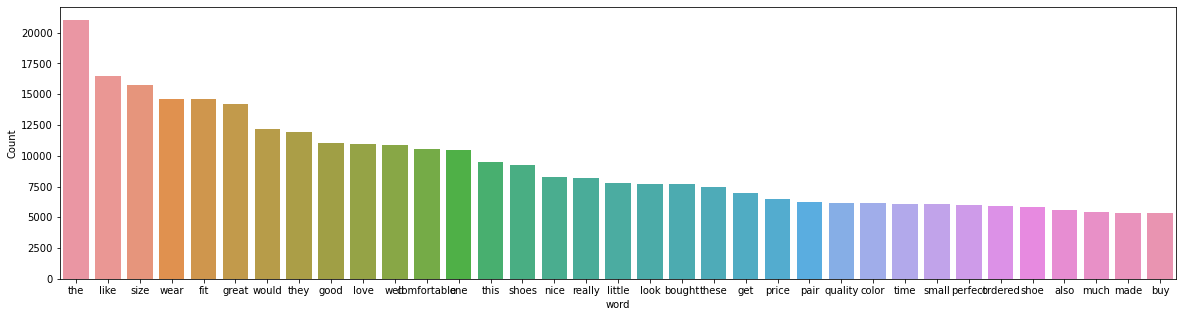

In [179]:
freq_words(reviews, 35)

### (3) Tokenize text

In [180]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['bought', 'purple', 'grey', 'size', 'pair', 'narrow', 'long', 'feet', 'hard', 'time', 'finding', 'shoes', 'wear', 'especially', 'since', 'wear', 'leather', 'suede', 'just', 'every', 'shoe', 'try', 'wide', 'rubs', 'blisters', 'feet', 'even', 'right', 'size', 'like', 'pretty', 'narrow', 'despite', 'medium', 'width', 'they', 'also', 'light', 'shoes', 'squishy', 'inside', 'really', 'comfortable', 'make', 'great', 'walking', 'shoes', 'tried', 'nikes', 'similar', 'wide', 'made', 'already', 'big', 'feet', 'look', 'even', 'bigger', 'they', 'also', 'rubbed', 'uncomfortably', 'skin', 'right', 'ankles', 'these', 'rub', 'blisters', 'feet', 'take', 'time', 'break', 'used', 'wear', 'converse', 'time', 'think', 'way', 'comfortable', 'though', 'still', 'like', 'converse', 'the', 'downside', 'pretty', 'expensive', 'happy', 'though', 'glad', 'got']


91

### we focus on noun and adjective


In [181]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [182]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [183]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])
len(reviews_2[1])

['purple', 'size', 'pair', 'narrow', 'long', 'foot', 'hard', 'time', 'shoe', 'leather', 'suede', 'shoe', 'wide', 'rub', 'blister', 'foot', 'right', 'size', 'narrow', 'medium', 'width', 'light', 'shoe', 'comfortable', 'great', 'shoe', 'nike', 'similar', 'big', 'foot', 'big', 'skin', 'right', 'ankle', 'rub', 'blister', 'foot', 'time', 'break', 'wear', 'converse', 'time', 'way', 'comfortable', 'downside', 'happy', 'glad']


47

In [184]:
print('The words that we removed:')
print(set(tokenized_reviews[1]) - set(reviews_2[1]))

The words that we removed:
{'despite', 'especially', 'make', 'like', 'rubs', 'inside', 'made', 'also', 'already', 'try', 'even', 'since', 'take', 'squishy', 'the', 'tried', 'really', 'bigger', 'bought', 'though', 'walking', 'every', 'feet', 'got', 'finding', 'look', 'shoes', 'ankles', 'grey', 'used', 'blisters', 'expensive', 'these', 'rubbed', 'nikes', 'just', 'think', 'uncomfortably', 'still', 'pretty', 'they'}


In [185]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

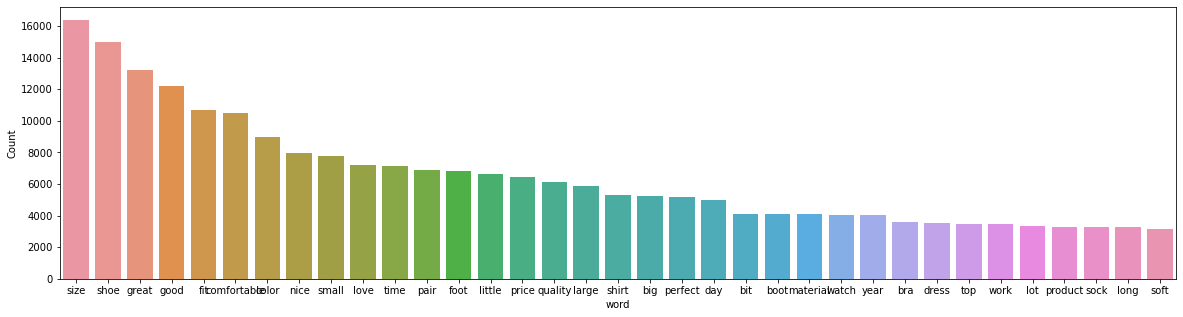

In [186]:
freq_words(df['reviews'], 35)

#### Now we have clean and imformative text available for topic modeling

# Topic Modeling

In [187]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [188]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [189]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [190]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [191]:
lda_model.print_topics()

[(0,
  '0.034*"good" + 0.027*"quality" + 0.025*"price" + 0.023*"product" + 0.021*"bag" + 0.020*"great" + 0.012*"time" + 0.011*"item" + 0.010*"cheap" + 0.009*"amazon"'),
 (1,
  '0.071*"color" + 0.045*"great" + 0.036*"love" + 0.029*"nice" + 0.028*"dress" + 0.024*"fit" + 0.021*"good" + 0.020*"perfect" + 0.019*"comfortable" + 0.017*"black"'),
 (2,
  '0.048*"watch" + 0.023*"gift" + 0.018*"band" + 0.017*"nice" + 0.017*"earring" + 0.016*"time" + 0.015*"beautiful" + 0.013*"price" + 0.012*"great" + 0.011*"big"'),
 (3,
  '0.051*"year" + 0.043*"ring" + 0.040*"old" + 0.026*"month" + 0.021*"son" + 0.018*"time" + 0.015*"wife" + 0.014*"daughter" + 0.012*"gold" + 0.011*"last"'),
 (4,
  '0.120*"size" + 0.043*"small" + 0.037*"fit" + 0.035*"large" + 0.028*"big" + 0.022*"pant" + 0.019*"little" + 0.014*"medium" + 0.014*"short" + 0.014*"bit"'),
 (5,
  '0.088*"shoe" + 0.040*"foot" + 0.035*"pair" + 0.032*"comfortable" + 0.023*"boot" + 0.019*"sock" + 0.015*"great" + 0.014*"day" + 0.013*"toe" + 0.012*"good"'),


In [192]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.013833 -0.100088       1        1  20.251498
0     -0.033863  0.144399       2        1  16.652202
4      0.175514 -0.135779       3        1  16.130394
6      0.082974 -0.167226       4        1  14.924324
1      0.117881  0.079357       5        1  14.775942
2      0.051213  0.234794       6        1  10.252329
3     -0.407553 -0.055457       7        1   7.013311, topic_info=      Term          Freq         Total Category  logprob  loglift
31    size  16069.000000  16069.000000  Default  30.0000  30.0000
29    shoe  14792.000000  14792.000000  Default  29.0000  29.0000
88   color   8735.000000   8735.000000  Default  28.0000  28.0000
14    foot   6676.000000   6676.000000  Default  27.0000  27.0000
118  watch   4076.000000   4076.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
6    water    342.235521    968.810847   Topic7  -5.1339   1.6168
988   next    312.120771    741.742623   Topic7  -5.2260   1.7917
52     day    438.757521   5015.975631   Topic7  -4.8854   0.2209
69     one    354.180010   2093.500206   Topic7  -5.0996   0.8806
474    use    298.923383   1916.258970   Topic7  -5.2692   0.7994

[429 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1828      5  0.996298  accessory
639       7  0.997206      adult
79        7  0.997691        age
73        1  0.200777     amazon
73        2  0.602332     amazon
...     ...       ...        ...
479       6  0.998457      wrist
127       1  0.259939       year
127       7  0.739846       year
300       2  0.849118     zipper
300       4  0.149188     zipper

[663 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 7, 2, 3, 4])

In [193]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.034*"good" + 0.027*"quality" + 0.025*"price" + 0.023*"product" + 0.021*"bag" + 0.020*"great" + 0.012*"time" + 0.011*"item" + 0.010*"cheap" + 0.009*"amazon"'),
 (1,
  '0.071*"color" + 0.045*"great" + 0.036*"love" + 0.029*"nice" + 0.028*"dress" + 0.024*"fit" + 0.021*"good" + 0.020*"perfect" + 0.019*"comfortable" + 0.017*"black"'),
 (2,
  '0.048*"watch" + 0.023*"gift" + 0.018*"band" + 0.017*"nice" + 0.017*"earring" + 0.016*"time" + 0.015*"beautiful" + 0.013*"price" + 0.012*"great" + 0.011*"big"'),
 (3,
  '0.051*"year" + 0.043*"ring" + 0.040*"old" + 0.026*"month" + 0.021*"son" + 0.018*"time" + 0.015*"wife" + 0.014*"daughter" + 0.012*"gold" + 0.011*"last"'),
 (4,
  '0.120*"size" + 0.043*"small" + 0.037*"fit" + 0.035*"large" + 0.028*"big" + 0.022*"pant" + 0.019*"little" + 0.014*"medium" + 0.014*"short" + 0.014*"bit"'),
 (5,
  '0.088*"shoe" + 0.040*"foot" + 0.035*"pair" + 0.032*"comfortable" + 0.023*"boot" + 0.019*"sock" + 0.015*"great" + 0.014*"day" + 0.013*"toe" + 0.012*"good"'),
